In [2]:
%pip install matplotlib

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/3e/f3/c5195b1ae57ef85339fd7285dfb603b22c8b4e79114bae5f4f0fcf688677/matplotlib-3.10.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/cc/8f/ec6289987824b29529d0dfda0d74a07cec60e54b9c92f3c9da4c0ac732de/contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/b7/37/82dbef0f6342eb01f54bca073ac1498433d6ce71e50c3c3282b655733b31/fonttools-4.61.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl (5.0 MB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/70/90/6d240beb0f24b74371762873e9b7f499f1e02166

In [3]:
import torch
import numpy as np
from PIL import Image   # 图像处理模块
from matplotlib import pyplot as plt
import os   # 导入os库，用于处理文件和目录路径
from torch.utils.data import Dataset,DataLoader   # 导入DataSet类，用于自定义数据集类型

In [4]:
# 自定义数据集类型，元素（noise_img_tensor, original_img_tensor）
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.main_dir = image_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir)    # 获取目录下所有图片文件名
    
    def __len__(self):
        return len(self.image_names)
    
    # 传入图片id，获取数据集元素 （x, y）
    def __getitem__(self, idx):
        # 1. 根据索引号，构建图片的完整路径
        image_loc = os.path.join(self.main_dir, self.image_names[idx])
        # 2. 使用 PIL 打开图片
        image = Image.open(image_loc).convert('RGB')
        # 3. 利用transform转换成tensor
        if self.transform is not None:
            tensor_img = self.transform(image)
        else:
            # 如果为None，就抛出异常
            raise ValueError("transform 参数不能为 None！")
        # 4. 向原始图像中增加噪声
        noise_factor = 0.5
        noise_img = tensor_img + noise_factor * torch.randn_like(tensor_img)
        noise_img = torch.clamp(noise_img, 0., 1.)
        
        # 返回 (噪声图片，原始图片)
        return noise_img, tensor_img

In [5]:
import torchvision.transforms as T  # 图像预处理模块

# 测试主流程
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.Resize((68, 68)),
    T.ToTensor()
])

# 1. 创建数据集
full_dataset = ImageDataset(image_dir='../common/dataset/', transform=transform)
print(len(full_dataset))

24853


In [6]:
from torch.utils.data import random_split 
# 2. 划分数据集
train_dataset, test_dataset = random_split(full_dataset, [0.75, 0.25])
print(len(train_dataset))
print(len(test_dataset))

18640
6213


In [7]:
# 3. 创建DataLoader
batch_size = 32
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    drop_last=True
)

In [8]:
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [9]:
for x, y in train_loader:
    print(f'x: {x}, x shape: {x.shape}, x device: {x.device}')
    print(f'y: {y}, y shape: {y.shape}, y device: {y.device}')
    break

x: tensor([[[[0.9713, 0.8249, 0.4556,  ..., 1.0000, 0.8284, 1.0000],
          [1.0000, 1.0000, 0.5209,  ..., 1.0000, 1.0000, 1.0000],
          [0.9663, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.2344],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.8601, 1.0000],
          [1.0000, 0.8230, 1.0000,  ..., 1.0000, 0.9776, 0.6388],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9067, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.6911],
          [0.8166, 0.3583, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 0.8489,  ..., 1.0000, 1.0000, 0.9290],
          [0.9250, 0.2374, 1.0000,  ..., 0.8209, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[0.9544, 0.5940, 1.0000,  ..., 0.2862, 0.6277, 0.3501],
          [0.7784, 0.2063, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.7933, 0.3971,  ...

In [10]:
import torch.nn as nn
# 定义神经网络结构类
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        # 编码器
        # 三个卷积层
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1)
        # 通用池化层
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 解码器
        # 三个转置卷积层
        self.t_conv1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        # 普通卷积层
        self.conv_out = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        # 编码
        x = torch.relu(self.conv1(x))
        # print("Conv1 output shape: ", x.shape)
        x = self.pool(x)
        # print("Pool1 output shape: ", x.shape)
        x = torch.relu(self.conv2(x))
        # print("Conv2 output shape: ", x.shape)
        x = self.pool(x)
        # print("Pool2 output shape: ", x.shape)
        x = torch.relu(self.conv3(x))
        # print("Conv3 output shape: ", x.shape)
        x = self.pool(x)
        # print("Pool3 output shape: ", x.shape)
        # 解码
        x = torch.relu(self.t_conv1(x))
        # print("T_Conv1 output shape: ", x.shape)
        x = torch.relu(self.t_conv2(x))
        # print("T_Conv2 output shape: ", x.shape)
        x = torch.relu(self.t_conv3(x))
        # print("T_Conv3 output shape: ", x.shape)
        x = torch.sigmoid(self.conv_out(x))
        # print("Conv output shape: ", x.shape)
        return x

In [11]:
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [12]:
# 随便输入一个数据进行前向传播测试
x = torch.randn(1, 3, 68, 68)
y = model(x)
print(y.shape)

torch.Size([1, 3, 68, 68])


In [13]:
# 定义损失函数和优化器
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
# 训练
num_epochs = 10

model.to(device)

for epoch in range(1, num_epochs + 1):
    train_loss = 0.0
    for noise_imgs, tensor_imgs in train_loader:
        # 0. 将数据移动到设备上
        noise_imgs = noise_imgs.to(device)
        tensor_imgs = tensor_imgs.to(device)
        # 1. 前向传播
        outputs = model(noise_imgs)
        # 2. 计算损失
        loss_value = loss(outputs, tensor_imgs)
        # 3. 反向传播
        loss_value.backward()
        # 4. 更新参数
        optimizer.step()
        # 5. 清除梯度
        optimizer.zero_grad()
        # 6. 累计损失
        train_loss += loss_value.item()
    # 本轮训练结束，计算平均损失
    this_loss = train_loss / len(train_loader)
    print(f'epoch: {epoch}, train_loss: {this_loss:.6f}')

epoch: 1, train_loss: 0.036483
epoch: 2, train_loss: 0.013445
epoch: 3, train_loss: 0.011470
epoch: 4, train_loss: 0.010755
epoch: 5, train_loss: 0.010430
epoch: 6, train_loss: 0.010163
epoch: 7, train_loss: 0.010011
epoch: 8, train_loss: 0.009866
epoch: 9, train_loss: 0.009753
epoch: 10, train_loss: 0.009645


In [15]:
# 验证模型效果
# 从测试数据加载器获取一个批次的测试图像数据
loader_iter = iter(test_loader)
noise_imgs, original_imgs = next(loader_iter)
print(noise_imgs.shape)
print(original_imgs.shape)

torch.Size([32, 3, 68, 68])
torch.Size([32, 3, 68, 68])


In [16]:
# 开始测试
model = model.to(device)
noise_imgs = noise_imgs.to(device)

outputs = model(noise_imgs)     # 前向传播

print(outputs.shape)

torch.Size([32, 3, 68, 68])


In [17]:
# 变换数据，准备画图
# 1. 噪声图像
noise_imgs = noise_imgs.permute(0, 2, 3, 1).cpu().numpy()
print("转换后的噪声图像形状：", noise_imgs.shape)

转换后的噪声图像形状： (32, 68, 68, 3)


In [18]:
# 2. 去噪图像
outputs = outputs.permute(0, 2, 3, 1).detach().cpu().numpy()
print("转换后的去噪图像形状：", outputs.shape)
# 3. 原始图像
original_imgs = original_imgs.permute(0, 2, 3, 1).cpu().numpy()
print("转换后的原始图像形状：", original_imgs.shape)

转换后的去噪图像形状： (32, 68, 68, 3)
转换后的原始图像形状： (32, 68, 68, 3)


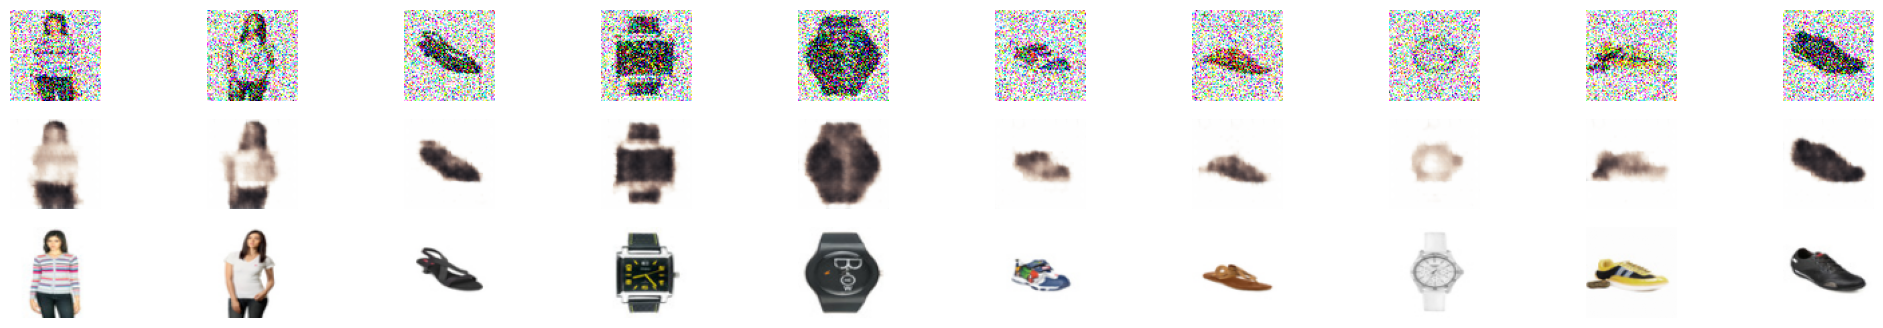

In [19]:
# 画图
fig, axes = plt.subplots(3, 10, figsize=(25, 4))
for imgs, row in zip([noise_imgs, outputs, original_imgs], axes):
    for img, ax in zip(imgs, row):
        ax.imshow(img)
        ax.axis('off')
plt.show()